In [72]:
import os
import datetime
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [144]:
experiments_record = {}

In [145]:
def parse_state(file_name: str):
    with open(file_name, 'r') as f:
        time_stamp = int(f.readlines()[0].split(' ')[-1]) / 1000.0
        exp_time = datetime.datetime.fromtimestamp(time_stamp)
        return {'trial_time': str(exp_time)}
def parse_metrics(file_name: str):
    with open(file_name, 'r') as f:
        content = f.read()
        file_head = content.split('{')[0]
        try:
            metric_details =  json.loads(content.replace(file_head, ''))
            return {
                'metric_id':file_head,
                **metric_details
            }
        except json.JSONDecodeError:
            print(file_name)
            print(content)
            return {}
def parse_parameters(file_name: str):
    with open(file_name, 'r') as f:
        content = f.read()
        return {k:v for k,v in json.loads(content).items()}
def parse_sqlite(file_name:str):
    try:
        conn = sqlite3.connect(file_name)
        c = conn.cursor()
        c.execute('SELECT * FROM ExperimentProfile')
        result = c.fetchall()
        c.execute("select name from sqlite_master where type = 'table'")
        c.execute("SELECT * FROM MetricData")
        end_time = max([i[0] for i in c.fetchall()])
        c.execute("SELECT * FROM TrialJobEvent")
        begin_time = min([i[0] for i in c.fetchall()])
    finally:
        conn.close()
    return {**json.loads(result[0][0]), 'duration': end_time - begin_time}

In [146]:
for root,directories, files in os.walk('../nni'):
    for file in files:
        file_name = '{}/{}'.format(root,file)
        if 'log' in file_name or 'run.sh' in file_name or 'stderr' in file_name:
            continue
        meta_data = file_name.split('/')
        experiment_id = meta_data[3]
        trial_id = meta_data[5]
        file_type = meta_data[-1]
        parse_dict = {
            'state': parse_state,
            'metrics': parse_metrics,
            'parameter.cfg': parse_parameters,
            'nni.sqlite': parse_sqlite,
        }
        file_data = parse_dict.get(file_type, print)(file_name)
        experiments_record[experiment_id] = experiments_record.get(experiment_id, {})
        if 'sqlite' not in trial_id:
            experiments_record[experiment_id]['trials'] = experiments_record[experiment_id].get('trials', [])
            trial_index = [i for i, v in enumerate(experiments_record[experiment_id]['trials']) if v.get('trial_id', '') == trial_id]
            if not trial_index:
                experiments_record[experiment_id]['trials'].append({'trial_id': trial_id})
                trial_index = len(experiments_record[experiment_id]['trials']) - 1
            else:
                trial_index = trial_index[0]
            experiments_record[experiment_id]['trials'][trial_index] = {
                **file_data,
                **experiments_record[experiment_id]['trials'][trial_index]   
            }
        else:
            tunner_info = { **file_data.get('advisor', {}), **file_data.get('tuner', {})}
            method_name = [v for k,v in tunner_info.items() if 'builtin' in k][0]
            experiments_record[experiment_id]['method'] = method_name
            experiments_record[experiment_id]['duration'] = file_data['duration']

../nni/experiments/MrUaVQmO/trials/QQD7j/.nni/metrics



In [147]:
with open('experiment_model1.json', 'w') as f:
    f.write(json.dumps(experiments_record, indent=2))

In [148]:
best_result = [{'method': v['method'],
 'best': max([float(i.get('value', '0')) for i in v['trials']]) }  for k,v in experiments_record.items()]
best_result_df = pd.DataFrame(best_result)
best_result_df = best_result_df.sort_values(['best'], ascending=False)

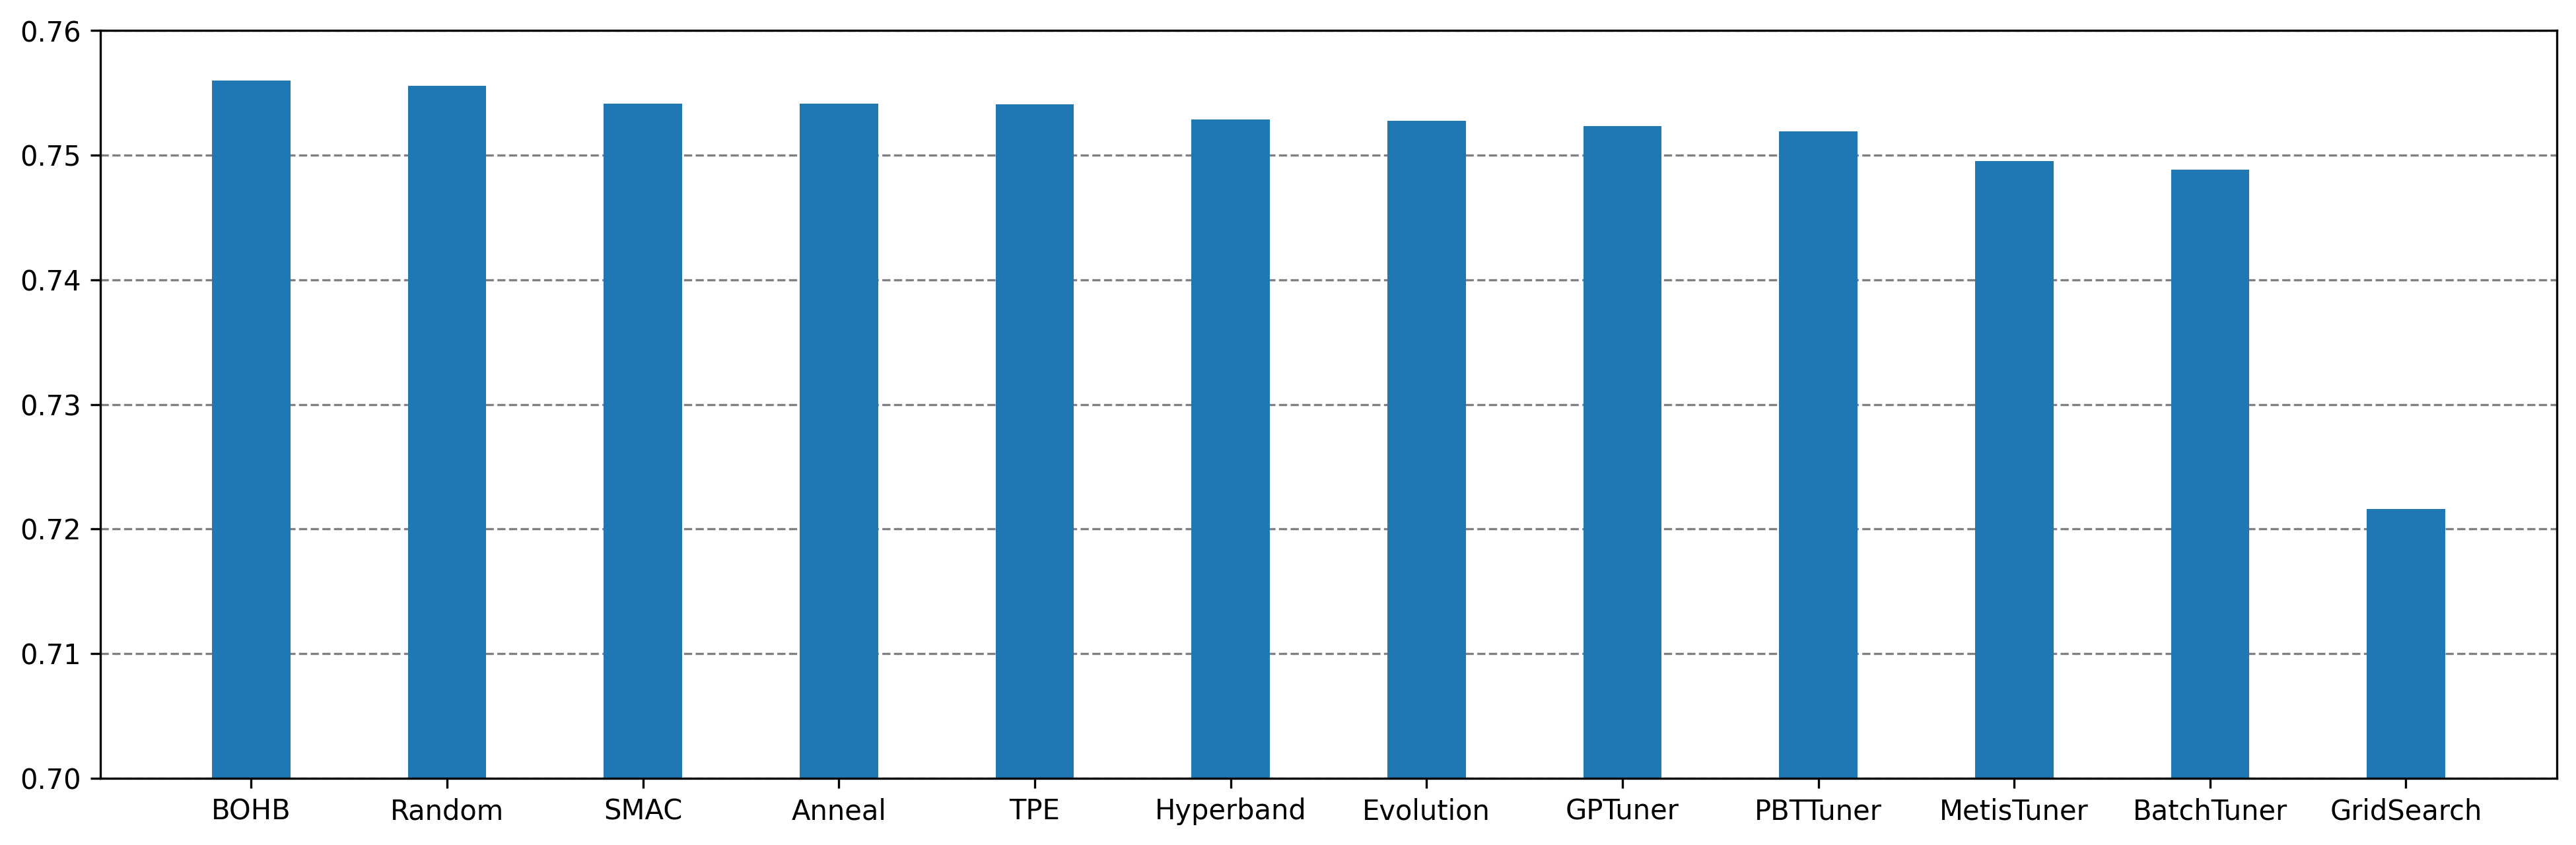

In [160]:
fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.set(ylim=[0.7,0.76])
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.bar(best_result_df['method'], best_result_df['best'], width=0.4)
plt.show()

In [161]:
durations = [{'method': v['method'], 'duration': v['duration'] / 1000.0} for k,v in experiments_record.items()]
durations_df = pd.DataFrame(durations)
durations_df = durations_df.sort_values(['duration'], ascending=True)
durations_df

,method,duration
9,GPTuner,6396.675
8,Evolution,6665.075
6,Random,7011.216
0,BOHB,7193.895
3,MetisTuner,7307.533
7,PBTTuner,7461.766
1,BatchTuner,7750.060
11,Hyperband,8271.297
5,GridSearch,8376.520
2,TPE,8845.661


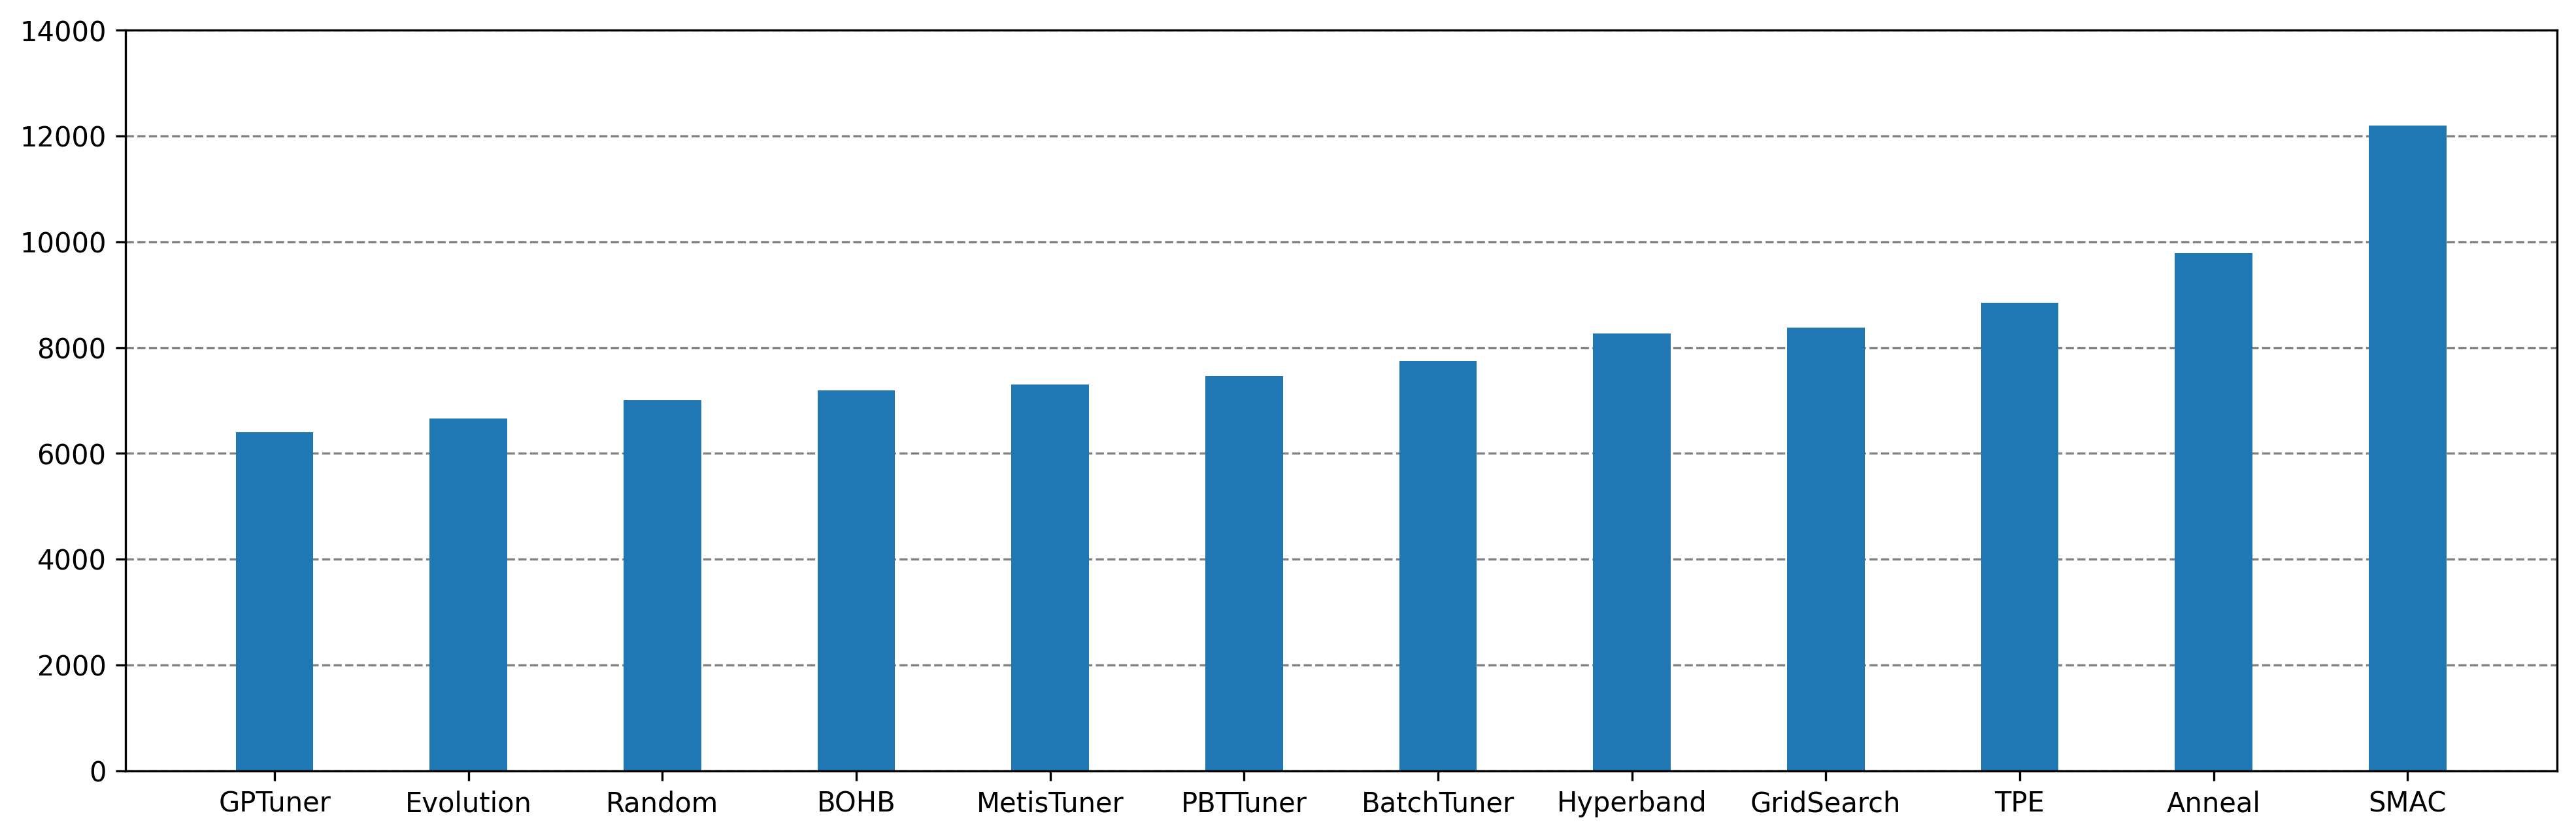

In [165]:
fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.set(ylim=[0,14000])
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.bar(durations_df['method'], durations_df['duration'], width=0.4)
plt.show()